## Jupyter Notebook : Text Clustering 

#### - Adirtha Borgohain

In [52]:
## Import all necessary libraries and modules
import math
import string
import gensim
import numpy as np
import numpy.matlib
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
%matplotlib inline

In [2]:
DATA_DIR = './'
FILE_NAME = 'text_to_cluster.txt'
delimiter = '\n'

In [3]:
## Reading the data file
df = pd.read_csv(DATA_DIR + FILE_NAME, delimiter=delimiter, header=None, names=["Headlines"])
df.head()

,Headlines
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 1 columns):
Headlines    684 non-null object
dtypes: object(1)
memory usage: 5.5+ KB


In [5]:
## Cleaning the text in headlines

filter_text = string.punctuation + '“”|”' + string.digits

df['Filter_Headlines'] = df['Headlines'].apply(lambda x: x.lower())
df['Filter_Headlines'] = df['Filter_Headlines'].apply(lambda x: x.translate(str.maketrans(filter_text,' '*len(filter_text),'')))
df_list = df['Filter_Headlines'].values

I used word embeddings in order to convert each of the word in our vocabulary to vectors. I downloaded pre-trained glove embeddings from *twitter27b* where each vector is of dimension 100. Once I load the word vectors to my gensim model, I tokenize each of the sentences into their words and find out the respective vectors for each word. In order to vectorize a complete sentence, I took the mean of each element of the word-vectors of a sentence in order to derive a single 100 dimension vector.

In [6]:
word_list = []
for line in df_list:
    temp_list = []
    for word in line.split():
        temp_list.append(word)
    word_list.append(temp_list)

In [7]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

In [8]:
## This cell is only to be executed once when we convert the pre-trained vector file format from 
## glove to word2vec format inorder to load it to our model

### Word-vectors downloaded from: 
###      https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt#glove.twitter.27B.100d.txt
### I have not included it in the zip file because the size is of 1 gb.
    
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec('glove.twitter.27B.100d.txt', 'glove27B.txt')

In [9]:
## Loading the model
model = gensim.models.KeyedVectors.load_word2vec_format('glove27B.txt', binary=False) 

In [10]:
X = []
for sentence in tqdm(word_list):
    X.append(sent_vectorizer(sentence, model))
X = np.array(X)

100%|██████████| 684/684 [00:00<00:00, 39716.81it/s]


In [11]:
X.shape

(684, 100)

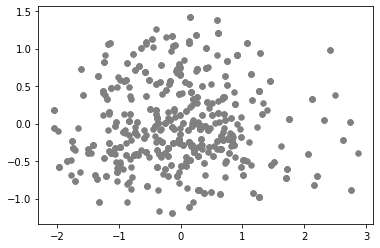

In [12]:
## We take a look at the distribution of the data after reducing the vectors to 2-dimensions through PCA
sklearn_pca = PCA(n_components = 2)
Y_PCA = sklearn_pca.fit_transform(X)
plt.scatter(Y_PCA[:, 0], Y_PCA[:, 1], c='grey', s=30)

In [13]:
## Initially setting a range of clusters to be evaluated from
min_clusters = 10
max_clusters = math.floor(math.sqrt(df.shape[0])) + 20

In [14]:
n_clusters = np.arange(min_clusters, max_clusters)
iterations = 10

In order to determine the number of clusters to give as input to the Gaussian Mixture Model, we will look at the distribution of **A**kaike **I**nformation **C**riterion (AIC) and **B**ayesian **I**nformation **C**riterion (BIC) for the model by setting different values of the number of clusters. This criterions gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC/AIC, the better is the model to actually predict the data we have, and by extension, the true, unknown, distribution. In order to avoid overfitting, this technique penalizes models with big number of clusters. 

### BIC

In [29]:
BIC = np.zeros(n_clusters.shape)
AIC = np.zeros(n_clusters.shape)

for i, n in tqdm(enumerate(n_clusters)):
    gmm=GMM(n, n_init=2).fit(X) 

    AIC[i] = gmm.aic(X)
    BIC[i] = gmm.bic(X)

36it [00:24,  1.49it/s]


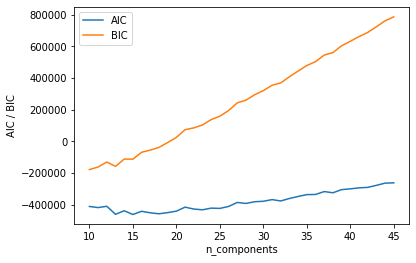

In [30]:
plt.figure()
plt.plot(n_clusters, AIC, label='AIC')
plt.plot(n_clusters, BIC, label='BIC')
plt.legend(loc=0)
plt.xlabel('n_components')
plt.ylabel('AIC / BIC')
plt.savefig('AIC-BIC.png')

We can notice two things here. Firstly, the curves (for both AIC and BIC) is fairly smooth and monotonic. The second is that the curves follows different slopes in different part of it. Taking into account these two observations, we will determine the number of clusters at the position where the BIC/AIC curve change slope is big.

### Determination of number of clusters

In [31]:
nPoints = len(AIC)
allCoord = np.vstack((range(min_clusters , max_clusters), AIC)).T
np.array([range(min_clusters, max_clusters), AIC])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)

In [32]:
n = min_clusters + idxOfBestPoint
print('The chosen value for number of clusters is: ', n)

The chosen value for number of clusters is:  18


### Defining the model and getting its results

In [33]:
gmm = GMM(n_components=n)
gmm.fit(X)
preds = gmm.predict(X)

In [34]:
## A dictionary is made wherein for each cluster keys, the index of rows belonging to it are stored as its values
cluster_dict = {i: np.where(preds == i)[0] for i in range(n)}
cluster_dict

{0: array([156, 247, 319, 365, 468, 501, 555, 558, 561, 642, 648]),
 1: array([ 92, 128, 129, 130, 131, 133, 136, 141, 142, 145, 146, 149, 155,
        159, 160, 161, 162, 163, 164, 165, 166, 171, 172, 179, 180, 225,
        231, 261, 268, 272, 288, 329, 330, 333, 339, 368, 369, 373, 375,
        379, 382, 389, 390, 391, 392, 395, 399, 442, 446, 449, 450, 452,
        453, 457, 472, 509, 510, 524, 529, 530, 536, 537, 541, 544, 562,
        563, 569, 572, 580, 586, 592, 606, 607, 619, 623, 624, 630, 631,
        632, 639, 649, 652, 655, 668, 669, 670, 671, 672, 677]),
 2: array([132, 147, 148, 150, 152, 181, 229, 232, 233, 242, 259, 265, 269,
        270, 286, 289, 291, 322, 332, 338, 370, 387, 413, 441, 443, 444,
        447, 448, 502, 521, 522, 542, 543, 583, 584, 587, 588, 591, 593,
        595, 605, 616, 625, 626, 629, 636, 637, 659, 682, 683]),
 3: array([  0,   1,   5,   7,  10,  12,  28,  94,  95,  97,  99, 125, 126,
        127, 138, 154, 183, 184, 186, 187, 198, 201, 227, 258, 

In [36]:
## A txt outfile file is created and the results are written to it as needed
output_file = open("output.txt","w") 

for key,value in cluster_dict.items():
    output_file.write('cluster id: ' + str(key) + '\n')
    for i in value:
        output_file.write(df['Headlines'].iloc[i] + '\n')
    output_file.write('*' * 100)
    output_file.write('\n')

### Use of Gaussian Mixture Model (GMM)

Gaussian mixture models can be used to cluster unlabeled data in much the same way as k-means. There are, however, advantages to using Gaussian mixture models over k-means which is why I used GMM in this case.

K-means only finds out clusters of circular shapes. It fails to cluster data together when arbitrary shaped clusters are needed. One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This works fine for when our data is circular. However, when our data takes on different shape, the results come out unexpected. In contrast, GMMs can handle even very oblong clusters and can determine arbitrary shaped clusters.

